<a href="https://colab.research.google.com/github/yuranranran/pneumonia-xray-detection/blob/main/pneumonia_xray_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Detection from Chest X-ray Images using CNN

## 1. Introduction
- Problem: Classify chest X-ray images into NORMAL or PNEUMONIA
- Dataset from Kaggle: [Chest X-ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)


# Step 1: download data set

In [ ]:
# Kaggle
!pip install -q kaggle

# kaggle.json
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yuranliuyuranranran","key":"f7dc96f5fdaf53e9c855c99003b5ed86"}'}

In [ ]:
# kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# download 2GB）
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# unzip
!unzip chest-xray-pneumonia.zip


Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

## 2. Dataset & EDA
- Folder structure: train/test/val with NORMAL and PNEUMONIA
- Sample count per category (bar chart)
- Visual samples of both classes


# Step 2: EDA

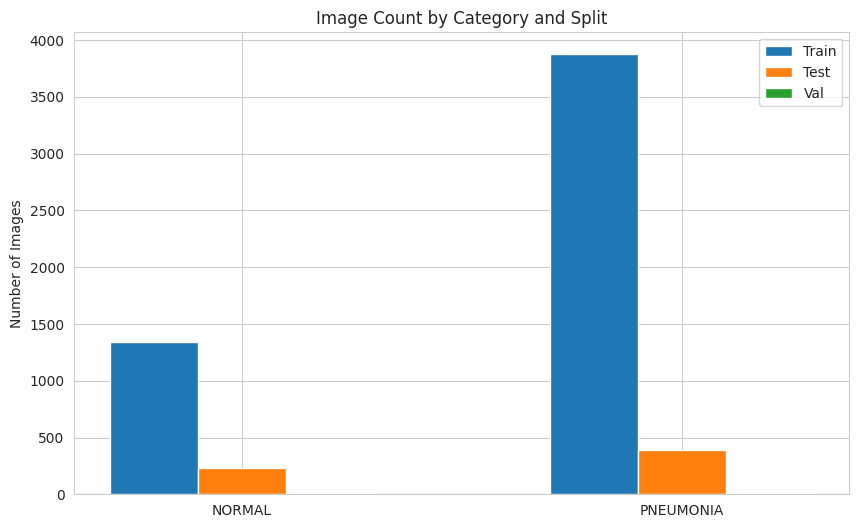

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random

# set path
base_dir = "chest_xray"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
val_dir = os.path.join(base_dir, "val")

# check distribution
def count_images(path):
    return {
        "NORMAL": len(os.listdir(os.path.join(path, "NORMAL"))),
        "PNEUMONIA": len(os.listdir(os.path.join(path, "PNEUMONIA")))
    }

train_counts = count_images(train_dir)
test_counts = count_images(test_dir)
val_counts = count_images(val_dir)

# data visulization
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
labels = ['NORMAL', 'PNEUMONIA']
train_vals = [train_counts['NORMAL'], train_counts['PNEUMONIA']]
test_vals = [test_counts['NORMAL'], test_counts['PNEUMONIA']]
val_vals = [val_counts['NORMAL'], val_counts['PNEUMONIA']]

x = range(len(labels))
plt.bar([i-0.2 for i in x], train_vals, width=0.2, label='Train')
plt.bar(x, test_vals, width=0.2, label='Test')
plt.bar([i+0.2 for i in x], val_vals, width=0.2, label='Val')

plt.xticks(x, labels)
plt.ylabel("Number of Images")
plt.title("Image Count by Category and Split")
plt.legend()
plt.show()


## 3. Model 1: Simple CNN Baseline
- Architecture: 3 Conv layers + Dense
- Training: 5 epochs
- Results: Training acc ~98%, Val acc ~87.5%
- Accuracy/Loss curves

# Step 3 Check some normal and pneumonia photo

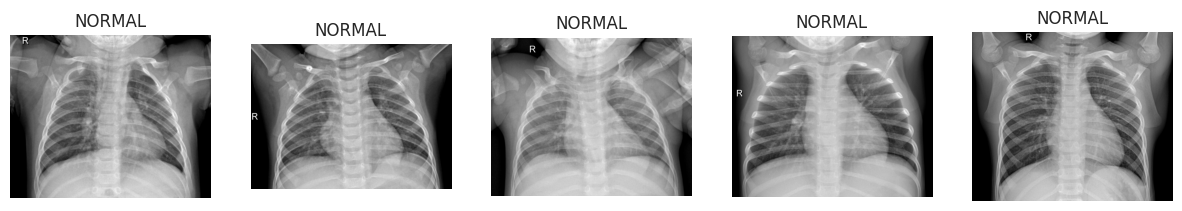

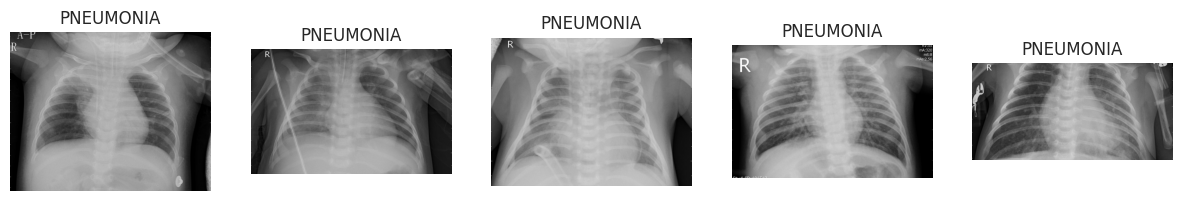

In [ ]:
def show_sample_images(img_dir, label, num=5):
    folder = os.path.join(img_dir, label)
    images = random.sample(os.listdir(folder), num)

    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(folder, img_name)
        img = Image.open(img_path)
        plt.subplot(1, num, i + 1)
        plt.imshow(img.convert("L"), cmap="gray")
        plt.title(f"{label}")
        plt.axis("off")
    plt.show()

# NORMAL
show_sample_images(train_dir, "NORMAL")

# PNEUMONIA
show_sample_images(train_dir, "PNEUMONIA")


## 4. Model 2: CNN + Data Augmentation
- Image augmentation: rotation, shift, flip, etc.
- Slightly lower val acc ~68-75% but improved generalization
- Accuracy/Loss curves
- *Discussion: overfitting reduced*

# Step 4: Train first CNN model, baseline

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

# parameter
BATCH_SIZE = 32
IMG_SIZE = (150, 150)

# image generator
train_gen = ImageDataGenerator(rescale=1./255)
valid_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data = valid_gen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# structure
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# implement
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# train
history = model.fit(
    train_data,
    epochs=5,  # 5 rounds first
    validation_data=val_data
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.8350 - loss: 0.3692 - val_accuracy: 0.6250 - val_loss: 0.8632
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.9647 - loss: 0.1051 - val_accuracy: 1.0000 - val_loss: 0.0966
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.9720 - loss: 0.0858 - val_accuracy: 0.9375 - val_loss: 0.1676
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.9811 - loss: 0.0540 - val_accuracy: 0.8750 - val_loss: 0.1350
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.9848 - loss: 0.0431 - val_accuracy: 0.8750 - val_loss: 0.1525


## 5. Model 3: EfficientNetB0 (Transfer Learning)
- Used pretrained imagenet weights
- Val accuracy stuck at 50% → unsuccessful model
- Accuracy/Loss curves
- *Discussion: needs further fine-tuning or custom layer adjustment*

# Step 5: Loss & Accuracy

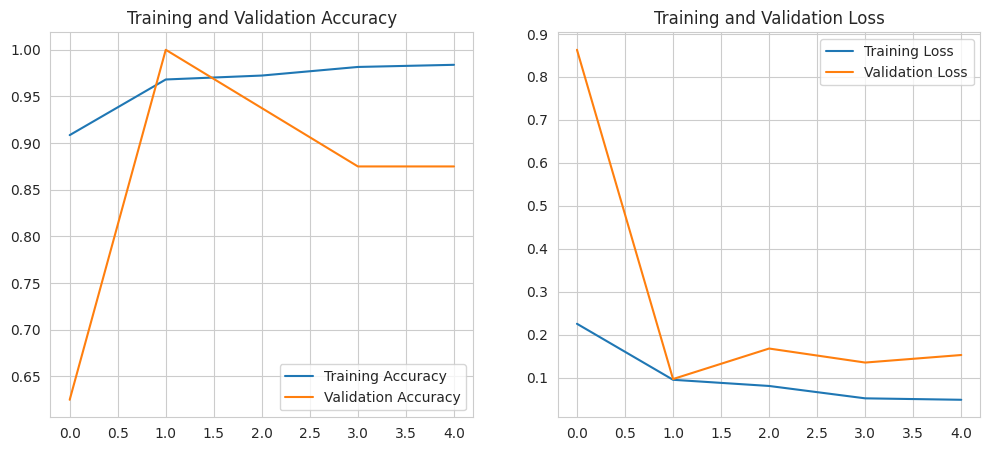

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


# Data Augmentation
# EfficientNetB0

In [ ]:
# ImageDataGenerator
train_gen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_train_data = train_gen_aug.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# CNN
model_aug = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_aug.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# 5 epoch
history_aug = model_aug.fit(
    augmented_train_data,
    epochs=5,
    validation_data=val_data
)


Found 5216 images belonging to 2 classes.
Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.7614 - loss: 0.6323 - val_accuracy: 0.8750 - val_loss: 0.6373
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.8711 - loss: 0.3170 - val_accuracy: 0.7500 - val_loss: 0.6075
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.9057 - loss: 0.2178 - val_accuracy: 0.7500 - val_loss: 0.7133
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.9313 - loss: 0.1801 - val_accuracy: 0.6875 - val_loss: 0.8291
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.9207 - loss: 0.1908 - val_accuracy: 0.6875 - val_loss: 0.4229


### Using data augmentation helped the model generalize better by introducing more variations to the training samples.

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

inputs = tf.keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
efficient_model = Model(inputs, outputs)

efficient_model.compile(optimizer='adam',
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

history_eff = efficient_model.fit(
    train_data,
    epochs=5,
    validation_data=val_data
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.7201 - loss: 0.5923 - val_accuracy: 0.5000 - val_loss: 0.8502
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.7557 - loss: 0.5623 - val_accuracy: 0.5000 - val_loss: 0.8685
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.7537 - loss: 0.5642 - val_accuracy: 0.5000 - val_loss: 0.8065
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.7423 - loss: 0.5738 - val_accuracy: 0.5000 - val_loss: 0.8397
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.7428 - loss: 0.5742 - val_accuracy: 0.5000 - val_loss: 0.9410


### Although EfficientNetB0 is a strong pretrained model, it failed to generalize on this small dataset, likely due to mismatch in training dynamics or hyperparameters. Further fine-tuning may be needed.

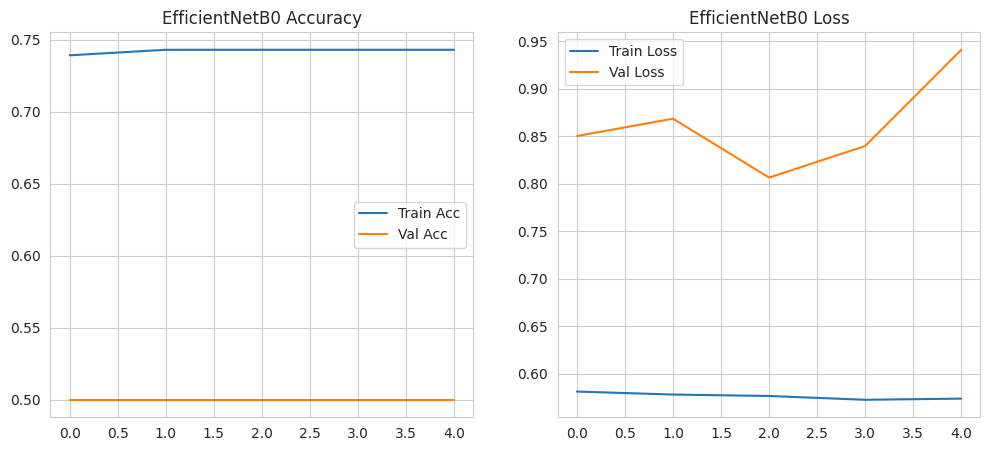

In [ ]:
acc = history_eff.history['accuracy']
val_acc = history_eff.history['val_accuracy']
loss = history_eff.history['loss']
val_loss = history_eff.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Acc')
plt.plot(epochs_range, val_acc, label='Val Acc')
plt.legend()
plt.title('EfficientNetB0 Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend()
plt.title('EfficientNetB0 Loss')

plt.show()


## 6. Comparison & Conclusion
| Model | Augmentation | Val Accuracy | Comment |
|-------|--------------|--------------|---------|
| Simple CNN | No | ~87.5% | Strong baseline |
| CNN + Aug | Yes | ~68–75% | Less overfit |
| EfficientNet | No | ~50% | Underperformed |

## 7. GitHub Link
[https://github.com/yuranranran/pneumonia-xray-detection](https://github.com/yuranranran/pneumonia-xray-detection)

## 8. Video Link